<a href="https://colab.research.google.com/github/Anahi0504/proyecto_final/blob/main/proyectofinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# CARGAR DATASET Y CREAR CLASE BINARIA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar dataset
df = sns.load_dataset("car_crashes")

print("\n>>> Primeras filas del dataset original:")
print(df.head())

print("\n>>> Columnas disponibles:")
print(df.columns)

# Crear variable objetivo binaria
# 0 = accidentes totales por debajo de la mediana (menor severidad)
# 1 = accidentes totales por encima de la mediana (mayor severidad)

median_total = df["total"].median()
df["severity_binary"] = (df["total"] > median_total).astype(int)

print("\n>>> Conteo de clases (0=bajo, 1=alto):")
print(df["severity_binary"].value_counts())



>>> Primeras filas del dataset original:
   total  speeding  alcohol  not_distracted  no_previous  ins_premium  \
0   18.8     7.332    5.640          18.048       15.040       784.55   
1   18.1     7.421    4.525          16.290       17.014      1053.48   
2   18.6     6.510    5.208          15.624       17.856       899.47   
3   22.4     4.032    5.824          21.056       21.280       827.34   
4   12.0     4.200    3.360          10.920       10.680       878.41   

   ins_losses abbrev  
0      145.08     AL  
1      133.93     AK  
2      110.35     AZ  
3      142.39     AR  
4      165.63     CA  

>>> Columnas disponibles:
Index(['total', 'speeding', 'alcohol', 'not_distracted', 'no_previous',
       'ins_premium', 'ins_losses', 'abbrev'],
      dtype='object')

>>> Conteo de clases (0=bajo, 1=alto):
severity_binary
0    26
1    25
Name: count, dtype: int64


In [7]:
# SELECCIÓN DE VARIABLES Y ESTADÍSTICAS

# Seleccionamos variables numéricas
features = ["speeding", "alcohol", "ins_losses", "severity_binary"]

df_small = df[features].dropna()

print("\n>>> Primeras filas del df filtrado:")
print(df_small.head())

print("\n>>> Estadísticas básicas del dataset:")
print(df_small.describe())



>>> Primeras filas del df filtrado:
   speeding  alcohol  ins_losses  severity_binary
0     7.332    5.640      145.08                1
1     7.421    4.525      133.93                1
2     6.510    5.208      110.35                1
3     4.032    5.824      142.39                1
4     4.200    3.360      165.63                0

>>> Estadísticas básicas del dataset:
        speeding    alcohol  ins_losses  severity_binary
count  51.000000  51.000000   51.000000        51.000000
mean    4.998196   4.886784  134.493137         0.490196
std     2.017747   1.729133   24.835922         0.504878
min     1.792000   1.593000   82.750000         0.000000
25%     3.766500   3.894000  114.645000         0.000000
50%     4.608000   4.554000  136.050000         0.000000
75%     6.439000   5.604000  151.870000         1.000000
max     9.450000  10.038000  194.780000         1.000000


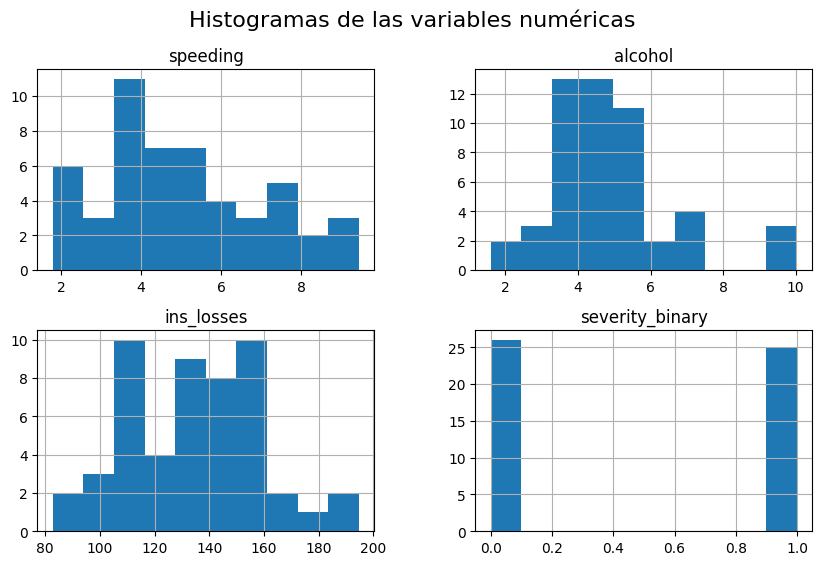

In [8]:
# HISTOGRAMAS

df_small.hist(figsize=(10, 6))
plt.suptitle("Histogramas de las variables numéricas", fontsize=16)
plt.show()


In [9]:
# TRAIN/TEST SPLIT MANUAL

np.random.seed(1)

msk = np.random.rand(len(df_small)) < 0.7
train = df_small[msk].values
test = df_small[~msk].values

print("\n>>> Train size:", len(train))
print(">>> Test size:", len(test))

print("\n>>> Proporción train:", msk.mean())
print(">>> Proporción test:", 1 - msk.mean())



>>> Train size: 37
>>> Test size: 14

>>> Proporción train: 0.7254901960784313
>>> Proporción test: 0.27450980392156865


In [10]:
# FUNCIONES KNN

import math
import operator

def euclideanDistance(instance1, instance2, length):
    distance = 0
    for x in range(length):  # comparamos columna por columna
        distance += (instance1[x] - instance2[x])**2
    return math.sqrt(distance)

def getNeighbors(trainingSet, testInstance, k):
    distances = []
    length = len(testInstance) - 1

    for x in range(len(trainingSet)):
        dist = euclideanDistance(testInstance, trainingSet[x], length)
        distances.append((trainingSet[x], dist))

    distances.sort(key=operator.itemgetter(1))
    neighbors = []

    for x in range(k):
        neighbors.append(distances[x][0])

    return neighbors

def getResponse(neighbors):
    classVotes = {}

    for x in range(len(neighbors)):
        response = neighbors[x][-1]  # etiqueta
        classVotes[response] = classVotes.get(response, 0) + 1

    sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)
    return sortedVotes[0][0]

def getAccuracy(testSet, predictions):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == predictions[x]:
            correct += 1
    return (correct / len(testSet)) * 100.0


In [11]:
# ENTRENAR Y PREDECIR

k = 5
predictions = []

for i in range(len(test)):
    neighbors = getNeighbors(train, test[i], k)
    result = getResponse(neighbors)
    predictions.append(result)

print("\n>>> Primeros 20 valores predichos:")
print(predictions[:20])

print("\n>>> Primeros 20 valores reales:")
print(test[:20, -1])

accuracy = getAccuracy(test, predictions)
print("\n>>> Accuracy del modelo:", accuracy, "%")



>>> Primeros 20 valores predichos:
[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(0.0), np.float64(1.0), np.float64(1.0)]

>>> Primeros 20 valores reales:
[1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0.]

>>> Accuracy del modelo: 57.14285714285714 %


In [12]:
# MATRIZ DE CONFUSIÓN

from sklearn.metrics import confusion_matrix

y_test = test[:, -1]
cm = confusion_matrix(y_test, predictions)

print("\n>>> MATRIZ DE CONFUSIÓN:")
print(cm)



>>> MATRIZ DE CONFUSIÓN:
[[4 4]
 [2 4]]


El modelo K-NN desarrollado permitió clasificar la severidad de accidentes viales utilizando variables como velocidad, alcohol y pérdidas aseguradas. A través del análisis exploratorio y del cálculo manual de distancias y vecinos, se comprendió cómo los datos pueden revelar patrones que distinguen entre accidentes de baja y alta severidad, mostrando que incluso modelos simples pueden generar resultados útiles para el análisis.

En el contexto de la ingeniería civil, este tipo de modelo es valioso para identificar zonas de mayor riesgo y apoyar decisiones de diseño, mejora y planificación de infraestructura vial. Al reconocer qué factores influyen en la gravedad de los accidentes, los ingenieros pueden priorizar intervenciones en seguridad, optimizar recursos y contribuir a la reducción de siniestros en carreteras y áreas urbanas.